<a href="https://colab.research.google.com/github/bryanfree66/colab_notebooks/blob/master/sentiment_analysis_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Identification Work Sample
## Data Description


1.   Number of records: 20000
2.   Text data
3.   Two string data type values per record
4.   Tagged for Sentiment (Positive, Negative, Neutral)
5.   The training data includes documents from a wide variety of sources

[Dataset link](http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set)

## Goal
* Train a sentiment classifier on the corpus of the dataset 
* Maximize accuracy of the classifier
* I want to be more sensitive to identifying negative

## Plan of Work
1. Load and clean up the data
2. Do some exploratory data analysis
3. Do some basic text feature engineering
4. Train and evaluate model(s)
5. Select best model based on accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
from google.colab import drive
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


warnings.filterwarnings("ignore")
sns.set(style="darkgrid")
drive.mount('/content/drive')
TRAIN_SPLIT = .8
SEED = 32
N_FOLDS = 3


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load the Data

In [2]:
%%time
# Use session storage
#df = pd.read_csv('/content/data/roman_urdu/Roman Urdu DataSet.csv',
#                 encoding='utf8')

# Use Google Drive
df = pd.read_csv('/content/drive/My Drive/working_data/roman_urdu/Roman Urdu DataSet.csv',
                 encoding='utf8')

# Save a clean copy for later
clean_copy = df.copy()  
print('Original data shape: {}'.format(df.shape))

Original data shape: (20228, 3)
CPU times: user 42.7 ms, sys: 8.73 ms, total: 51.4 ms
Wall time: 57.8 ms


I can see right away the dataset is not the shape I expected. The data description has two columns, but we seem to be picking up an extra column from the CSV.

In [3]:
df.head()

,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive,Unnamed: 2
0,sahi bt h,Positive,NaN
1,"Kya bt hai,",Positive,NaN
2,Wah je wah,Positive,NaN
3,Are wha kaya bat hai,Positive,NaN
4,Wah kya baat likhi,Positive,NaN


It looks like an extra column I wasn`t expecting. I´m also going to rename the first columns. I will set up a data pipeline later to automate all of the changes.  I´ll start by renaming the columns for convenience.

### Initial Cleaning

In [0]:
colunm_names = ['phrase','target','unexpected']
df.columns = colunm_names

In [5]:
df.head()

,phrase,target,unexpected
0,sahi bt h,Positive,NaN
1,"Kya bt hai,",Positive,NaN
2,Wah je wah,Positive,NaN
3,Are wha kaya bat hai,Positive,NaN
4,Wah kya baat likhi,Positive,NaN


In [6]:
df['unexpected'].value_counts()

till here           2
----------          1
-------             1
9090                1
----------------    1
------              1
Name: unexpected, dtype: int64

I´m going to go ahead and drop the extra column.

In [0]:
df.drop('unexpected', axis=1, inplace=True)

## Data Exploration

Let´s take a look at the details of the dataset.

### View Distribution of Targets

In [8]:
phrase_col = 'phrase'
target_col = 'target'
df[target_col].value_counts()

Neutral     8929
Positive    6012
Negative    5286
Neative        1
Name: target, dtype: int64

We have an unexpected value in our labels. We will have to account for that in the pipeline. I´m going to drop it, because I can´t automate for every spelling error in the labels.

In [9]:
correct_labels = ['Positive', 'Negative', 'Neutral']
df = df[df.target.isin(correct_labels)]
df[target_col].value_counts()

Neutral     8929
Positive    6012
Negative    5286
Name: target, dtype: int64

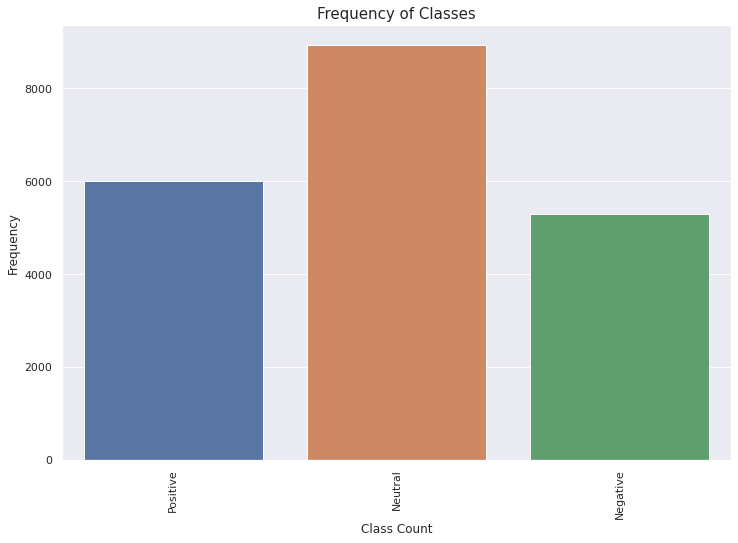

In [10]:
plt.figure(figsize=(12,8))
sns.countplot(x=target_col, data=df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

We have quite a few more neutral reviews than positive and negative. The positive and negative counts are close enough.

**`Requirement:`** One of the requirements of the work sample is to document how data limitations impact the result, and what I might do on a larger project.

When the class distribution is unbalanced, the model favors predicting the most frequent class. Accuracy can be a poor choice of evaluation metric for a classifier if the data is unbalanced as well.

On a larger project, I might consider a technique such as GAN minority oversampling to balance out the dataset.

The simplest way to fix imbalanced dataset is simply balancing them by oversampling instances of the minority class or undersampling instances of the majority class. That is what I will choose to do in this case.



In [11]:
df.describe()

,phrase,target
count,20226,20227
unique,19662,3
top,Good,Neutral
freq,23,8929


### Check for Empty Records

In [12]:
df.isnull().sum()

phrase    1
target    0
dtype: int64

There is one null review. I will deal with that in a bit.



### Duplicate Rows Check

In [13]:
print(df[df.duplicated(keep='first')])

                                                  phrase    target
19                                          jee ye to he  Positive
411                                             Hahahaha  Positive
585      Kabhi aap dusro k lye Dil se dua mang kr dekho   Positive
596    Karachi K Badalte Hue Halaat Or Nit Nayi Faida...  Positive
602    Aaj Bhi Shehar Me Target Killing Ka Koi Waqia ...  Positive
...                                                  ...       ...
17581  Or agr ye jhota wada howa to pti waly khud is ...  Negative
18207                              Conse colr may chaiye   Neutral
18354  Dhoka ha ye site plx mat Len ink products frau...  Negative
18363  Dhoka ha ye site plx mat Len ink products frau...  Negative
19543                                           Kia huwa   Neutral

[543 rows x 2 columns]


I'm going to drop those duplicates later.

## Feature Engineering

Now that we have discovered the basic cleanup procedures required, I am going to some basic text feature engineering.

**`Requirement:`**  The requirements from the customer specify evolving this solution into a multilingual sentiment application. 

For this work sample, I have to predict sentiment in Roman Urdu, which is not a supported language by common Python natural language processing tools. So, I have to build my own custom corpus and vocabulary.


For a production system, if the client requirements did not involve unsupported languages, I would put all of the data preperation and feature engineering steps into an SKLearn pipeline. I this would produce more repeatable and reliable model training process.

An academic paper on multilingual pipelines can be found [here](https://www.frederikhogenboom.nl/work/papers/wise11-slang.pdf).

I might still put the training and evaluation bits into a pipeline, just to demonstrate the concepts.

In [0]:
# Revert to a clean copy
df = clean_copy.copy()

# Basic clean up
df.columns = ['phrase', 'target', 'unexpected']
df.drop('unexpected', axis=1, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(keep='first', inplace = True)
df = df[df.target.isin(['Positive', 'Negative', 'Neutral'])]

### Encode the Labels

In [0]:
# Target selection and encoding
encoder = LabelEncoder()
targets = df.iloc[:,1].values
y = encoder.fit_transform(targets)
y_len = len(y)

### Create A Roman Urdu Corpus

Roman Urdu stopwords list from [GitHub](https://github.com/mirfan899/roman-urdu-stopwords/blob/master/stopwords.txt).

In [0]:
corpus = []
stopwords = ['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 
           'woh', 'bhi', 'aur', 'wo', 'yeh', 'rha', 'hota', 'ho', 'ga', 'ka', 
           'le', 'lye', 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya', 
           'gaya', 'kch', 'ab', 'thy', 'thay', 'houn', 'hain', 'han', 'to', 
           'is', 'hi', 'jo', 'kya', 'thi', 'se', 'pe', 'phr', 'wala', 'waisay', 
           'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski', 
           'ne', 'haan', 'acha', 'nai', 'sent', 'photo', 'you', 'kafi', 'gai', 
           'rhy', 'kuch', 'jata', 'aye', 'ya', 'dono', 'hoa', 'aese', 'de', 
           'wohi', 'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna', 
           'gi', 'hova', 'yehi', 'jana', 'jye', 'chal', 'mil', 'tu', 'hum', 
           'par', 'hay', 'kis', 'sb', 'gy', 'dain', 'krny', 'tou']
for i in range(0, y_len):
    phrase = re.sub('[^a-zA-Z]', ' ', df.iloc[:,0].values[i])
    phrase = phrase.lower()
    phrase = phrase.split()
    phrase = [word for word in phrase if not word in stopwords]
    phrase = ' '.join(phrase)
    corpus.append(phrase)

In [17]:
print('Length of corpus: {}'.format(len(corpus)))

Length of corpus: 19683


### Build the Vocabulary

In [0]:
vectorizer = CountVectorizer(max_features=2500)
X = vectorizer.fit_transform(corpus).toarray() 

### Under-sampling to Balance the Dataset

In [0]:
rus = RandomUnderSampler(random_state=17)
X_resampled, y_resampled = rus.fit_resample(X, y)

### Make Test Train Split

In [0]:
  
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    train_size=TRAIN_SPLIT,
                                                    shuffle=True,
                                                    random_state=SEED)
folds = KFold(n_splits = N_FOLDS, shuffle=True, random_state=SEED)

## Build and Train the Classifiers

In [21]:
lr_model=LogisticRegression()
lr_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
y_pred=lr_model.predict(X_test)
lr_matrix=confusion_matrix(y_test,y_pred)
print(lr_matrix)
print('LR Model Acc: {} '.format(accuracy_score(y_test, y_pred)))

[[596 283 145]
 [191 687 161]
 [186 270 628]]
LR Model Acc: 0.6072449952335558 
